In [3]:
!pip install langgraph langchain langchain_groq langchain_community

In [5]:
!pip install arxiv wikipedia

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached soupsieve-2.6-py3-none-any.whl.metadata (4.6 kB)
Using cached beautifulsoup4-4.12.3-py3-none-any.whl (147 kB)
Using cached soupsieve-2.6-py3-none-any.whl (36 kB)
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11706 sha256=

In [38]:
from typing import Annotated
from typing_extensions import TypedDict

In [39]:
## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv tool
arxiv_wrapp = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=500)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapp)

#wikitool

wiki_wrapp = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki_tool = WikipediaQueryRun(api_wrapper=wiki_wrapp)

In [40]:
wiki_tool.invoke("who is prashant")

'Page: Prashant Kishor\nSummary: Prashant Kishor Pandey, colloquially known as PK, is an Indian political strategist and tactician. He worked in public health programmes funded by the United Nations for eight years before venturing into Indian politics and working as a political strategist.\nKishor has worked as a political  strategist for BJP to gain his knowledge then he worked for the BJP, JD(U), INC, AAP, YSRCP, DMK and TMC. His first major political campaign was in 2011 to help Narendra Modi, '

In [41]:
arxiv_tool.invoke("LLM Defenses Are Not Robust to Multi-Turn Human Jailbreaks Yet")

"Published: 2024-08-27\nTitle: LLM Defenses Are Not Robust to Multi-Turn Human Jailbreaks Yet\nAuthors: Nathaniel Li, Ziwen Han, Ian Steneker, Willow Primack, Riley Goodside, Hugh Zhang, Zifan Wang, Cristina Menghini, Summer Yue\nSummary: Recent large language model (LLM) defenses have greatly improved models'\nability to refuse harmful queries, even when adversarially attacked. However,\nLLM defenses are primarily evaluated against automated adversarial attacks in a\nsingle turn of conversation, an in"

In [42]:
tools = [wiki_tool]

In [43]:
## Langgraph

from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [44]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

In [45]:
##LLM

import os 
from dotenv import load_dotenv

load_dotenv()

GROQ_API_KEY = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq

llm = ChatGroq(model = "llama-3.1-8b-instant",
            temperature=0.0,
            groq_api_key = GROQ_API_KEY)


In [46]:
llm_with_tools = llm.bind_tools(tools=tools)

In [47]:
def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

In [48]:
from langgraph.prebuilt import ToolNode, tools_condition

In [49]:
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [50]:
graph = graph_builder.compile()

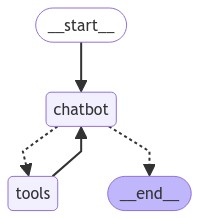

In [51]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [52]:
user_input="Hi there!, My name is John"

events=graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there!, My name is John
================================== Ai Message ==================================

Hello John, it's nice to meet you. Is there anything I can help you with today?


In [53]:
user_input="Who is Jaun Elia"

events=graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Who is Jaun Elia
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_9rvr)
 Call ID: call_9rvr
  Args:
    query: Juan Elia
================================= Tool Message =================================
Name: wikipedia

Page: Juan Elía
Summary: Juan 'Juantxo' Elía Vallejo (born 24 January 1979) is a Spanish former professional footballer who played as a goalkeeper.
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_frhp)
 Call ID: call_frhp
  Args:
    query: Juan Elia
================================= Tool Message =================================
Name: wikipedia

Page: Juan Elía
Summary: Juan 'Juantxo' Elía Vallejo (born 24 January 1979) is a Spanish former professional footballer who played as a goalkeeper.
================================== Ai Message ===============================

In [55]:

user_input="give me 4 lines of poem written by Syed Sibt-e-Asghar Naqvi"

events=graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

give me 4 lines of poem written by Syed Sibt-e-Asghar Naqvi
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_8wgp)
 Call ID: call_8wgp
  Args:
    query: Syed Sibt-e-Asghar Naqvi poem
================================= Tool Message =================================
Name: wikipedia

Page: Jaun Elia
Summary: Syed Sibt-e-Asghar Naqvi, commonly known by his pen-name Jaun Elia (Urdu: جون ایلیا, 14 December 1931 – 8 November 2002), was a Pakistani poet, philosopher, biographer and scholar.
One of the most prominent modern Urdu poets, popular for his unconventional ways, he "acquired knowledge of philosophy, logic, Islamic history, the Muslim Sufi tradition, Muslim religious sciences, Western literature, and Kabbala". He was fluent in Urdu, Arabic, Sindhi, English, Persian, Sansk
================================== Ai Message ===========================

In [56]:
user_input="give me the timeline of vietnam war"

events=graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

give me the timeline of vietnam war
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_7r7n)
 Call ID: call_7r7n
  Args:
    query: Vietnam War timeline
================================= Tool Message =================================
Name: wikipedia

Page: Vietnam War
Summary: The Vietnam War was a conflict in Vietnam, Laos, and Cambodia from 1 November 1955 to the fall of Saigon on 30 April 1975. It was the second of the Indochina Wars and a major conflict of the Cold War. While the war was officially fought between North Vietnam and South Vietnam, the north was supported by the Soviet Union, China, and other countries in the Eastern Bloc, while the south was supported by the US and anti-communist allies. This made it a proxy war between th
================================== Ai Message ==================================
Tool Calls:
  wikipedia (

In [57]:
user_input="what are the major events happned in vietnam war"

events=graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what are the major events happned in vietnam war
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_km84)
 Call ID: call_km84
  Args:
    query: Major events of the Vietnam War
================================= Tool Message =================================
Name: wikipedia

Page: Vietnam War
Summary: The Vietnam War was a conflict in Vietnam, Laos, and Cambodia from 1 November 1955 to the fall of Saigon on 30 April 1975. It was the second of the Indochina Wars and a major conflict of the Cold War. While the war was officially fought between North Vietnam and South Vietnam, the north was supported by the Soviet Union, China, and other countries in the Eastern Bloc, while the south was supported by the US and anti-communist allies. This made it a proxy war between th
================================== Ai Message ==================================
T

In [58]:
user_input="what is project 75 alpha"

events=graph.stream(
    {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is project 75 alpha
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_09rt)
 Call ID: call_09rt
  Args:
    query: Project 75 Alpha
================================= Tool Message =================================
Name: wikipedia

Page: Project 75 Alpha
Summary: Project 75 Alpha (also referred to as Project 77) is a programme of the Indian Navy which aims to procure new nuclear-powered attack submarines. The Government of India (CCS) approved the construction of six of such submarines in February 2015. These will be designed by the Navy's in-house Directorate of Naval Design (now Warship Design Bureau) and built in India at the Shipbuilding Centre at Visakhapatnam. The construction was expected to commence on 2023-24 whil
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_avk1)
 Cal